# Load data

In [68]:
#from structure_and_load import load
import matplotlib.pyplot as plt 
import numpy as np
import pandas as pd
import scipy.ndimage as spn 

import re
import neo 
import os
import sys

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [69]:
from matlab_file import open

In [70]:
lab_desktop = True

if lab_desktop : 
    session = 't150204001'
    data_path = f'/home/INT/mifsud.l/Bureau/data/Tommy/{session}/modified_data/' #f'~/Bureau/data/Tommy/{session}/modified_data'
    info_path = '/home/INT/mifsud.l/Bureau/Lists&Documentation/TomyCerebusSpikes_Updated_June2023.xlsx'

else : 
    session = 't150204001'
    data_path = f'/home/laurie/Bureau/pattern_classification/data/Tommy_new/{session}/modified_data/'
    info_path = '/home/laurie/Bureau/pattern_classification/data/Tommy_new/session_info.xlsx'

print(f'session : {session}')

session : t150204001


In [71]:
data, load_info = open(data_path)

loading t150204001_probe1_contact23_unit2.mat
loading t150204001_probe1_contact5_unit1.mat
loading t150204001_probe1_contact3_unit1.mat
loading t150204001_probe1_contact1_unit1.mat
loading t150204001_probe2_contact6_unit1.mat
loading t150204001_probe2_contact24_unit1.mat
loading t150204001_probe2_contact10_unit1.mat
loading t150204001_probe2_contact23_unit2.mat
loading t150204001_probe2_contact23_unit1.mat
loading t150204001_probe1_contact11_unit1.mat
loading t150204001_probe1_contact18_unit1.mat
loading t150204001_probe1_contact22_unit2.mat
loading t150204001_probe2_contact7_unit3.mat
loading t150204001_probe1_contact14_unit1.mat
loading t150204001_probe1_contact12_unit1.mat
loading t150204001_probe2_contact20_unit1.mat
loading t150204001_probe2_contact2_unit1.mat
loading t150204001_probe2_contact7_unit4.mat
loading t150204001_probe2_contact17_unit1.mat
loading t150204001_probe2_contact14_unit1.mat
loading t150204001_probe1_contact6_unit1.mat
loading t150204001_probe1_contact2_unit1.m

# Stucture

## info session / units

In [72]:
df = pd.read_excel(info_path)
df.dropna(how='all', inplace=True)
df.drop(columns=['BehDir', 'pitch', 'A/P', 'Lat', 'depth', 'SNR', 'Unnamed: 14', 'depth (no buffer)'], inplace=True)
df.rename(columns={'%Plexon_spike_file' : 'Plexon_spike_file'}, inplace=True)
float_column_names = df.select_dtypes(include=['float']).columns
df[float_column_names] = df[float_column_names].astype(int)

In [73]:
list_prob = []
list_chan = []
list_unit = []

info_units = []

for i in range(len(load_info)) :
    matfile = load_info[i][1]
    # get contact and unit indices from filename
    match_probe = re.search(r'probe(\d+)', matfile)
    match_contact = re.search(r'contact(\d+)', matfile)
    match_unit = re.search(r'unit(\d+)', matfile)

    info_units.append({
        'probe':int(match_probe.group(1)), 
        'contact':int(match_contact.group(1)), 
        'unit':int(match_unit.group(1))})


    list_prob.append(int(match_probe.group(1)))
    list_chan.append(int(match_contact.group(1)))
    list_unit.append(int(match_unit.group(1)))

#info_units = pd.DataFrame(info_units)
sub_info_session = df[df['Plexon_spike_file'].str.startswith(f'{session}')]


info_session = pd.DataFrame()
list_idx = []
for i in range(len(list_unit)):
    sub_data = sub_info_session[(sub_info_session['probe'] == list_prob[i]) & (sub_info_session['channel'] == list_chan[i]) & (sub_info_session['unit'] == list_unit[i])]
    list_idx.append(sub_data.index[0])
    info_session = pd.concat((info_session, sub_data))

In [74]:
def convert_elitrials(entry):
    if pd.notna(entry):  # Check for NaN
        # Remove square brackets and split by space to separate pairs
        pairs = entry.replace('[', '').replace(']', '').split()
        result = []
        for pair in pairs:
            start, end = map(int, pair.split(':'))
            result.append([start, end])
        return result
    else:
        return None
        
info_session['elitrials'] = info_session['elitrials'].apply(convert_elitrials)

In [75]:
info_session

,Plexon_spike_file,probe,channel,unit,start,stop,"SUA (1), MUA (2), unstable (3) few trials (4) or observation (5)",elitrials
179,t150204001_chan_01_24_new,1,23,2,1,8,1,None
161,t150204001_chan_01_24_new,1,5,1,8,11,1,"[[123, 128]]"
159,t150204001_chan_01_24_new,1,3,1,1,11,1,None
156,t150204001_chan_01_24_new,1,1,1,5,8,1,"[[132, 139]]"
187,t150204001_chan_25_48_new,2,6,1,6,9,1,None
208,t150204001_chan_25_48_new,2,24,1,5,8,1,"[[129, 139]]"
193,t150204001_chan_25_48_new,2,10,1,8,11,1,"[[123, 128]]"
207,t150204001_chan_25_48_new,2,23,2,6,11,1,None
206,t150204001_chan_25_48_new,2,23,1,1,3,1,None
166,t150204001_chan_01_24_new,1,11,1,5,8,1,None


In [76]:
first_bloc = info_session['start'].min()
last_bloc = info_session['stop'].max()

print(f'start / stop:\n   {first_bloc} /   {last_bloc}')

tasktime = info_session[(info_session['start'] == first_bloc) & (info_session['stop'] == last_bloc) & (info_session['elitrials'].isna())]
tasktimeComplete = tasktime.shape[0] != 0

if tasktimeComplete :
    unit_info = tasktime[['probe', 'channel', 'unit']].values[0]
    print(f"{tasktime[['start', 'stop', 'elitrials']]} \n\nunit_info : {unit_info}")
    matfile = f'{session}_probe{unit_info[0]}_contact{unit_info[1]}_unit{unit_info[2]}.mat'

    for i in load_info:
        if i[1] == matfile:
            completeUnit = i[0]
            print(f"{i[1]}\n\nunit's loading index = {completeUnit}")

else :
    print('ANY UNIT RECORDED OVER ENTIRE SESSION') 
    print(f"check here to construct session times by hand :\n {info_session['start'] == first_bloc}")

tasktime

start / stop:
   1 /   11
     start  stop elitrials
159      1    11      None 

unit_info : [1 3 1]
t150204001_probe1_contact3_unit1.mat

unit's loading index = 2


,Plexon_spike_file,probe,channel,unit,start,stop,"SUA (1), MUA (2), unstable (3) few trials (4) or observation (5)",elitrials
159,t150204001_chan_01_24_new,1,3,1,1,11,1,None


# Exctract data

In [77]:
data[0]['Touch_time'].shape

(138,)

In [78]:
# get spike train / periodes times / target info
spike_times = []
task_data = []
target_info = []
target_keys = ['SC1_dir', 'SC2_dir', 'SC3_dir', 'Trial_type']
event_keys_OFF = ['Sel_OFF', 'SC1_OFF', 'SC2_OFF', 'SC3_OFF']


for unit_idx in range(len(data)):
    spike_times.append((load_info[unit_idx], data[unit_idx]['ts']))  

    # List of keys to extract (excluding 'ts', cues direction and times OFF to be constistent with previous results)
    times_keys = [key for key in data[unit_idx] if key != 'ts' and key not in target_keys and key not in event_keys_OFF]
    task_info = {}
    for key_time in times_keys :
        task_info[key_time] = data[unit_idx][key_time]
    task_data.append((load_info[unit_idx],task_info))
    target_ = {}
    for key_target in target_keys :
        target_[key_target] = data[unit_idx][key_target]
    target_info.append((load_info[unit_idx], target_))

    event_labels = list(task_data[0][1].keys())


print(f'spike train sample : {spike_times[0][1]}\nevents : {event_labels}\ntargets : {target_info[0][1].keys()}')

spike train sample : [    237    2137    3267 ... 3657198 3657250 3658579]
events : ['Touch_time', 'Sel_ON', 'SC1_ON', 'SC2_ON', 'SC3_ON', 'Go_time', 'Target_time']
targets : dict_keys(['SC1_dir', 'SC2_dir', 'SC3_dir', 'Trial_type'])


In [79]:
target_info[completeUnit][1]['Trial_type']

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2],
      dtype=uint8)

In [80]:
target_1 = np.where(target_info[completeUnit][1]['Trial_type'] == 1)[0]
target_2 = np.where(target_info[completeUnit][1]['Trial_type'] == 2)[0]
target_3 = np.where(target_info[completeUnit][1]['Trial_type'] == 3)[0]

# Time formating

In [81]:
# get event times by trial for each neuron
def events(task_data):
    """
    Retrieves event times from task data file sorts them for each unit

    Args:
    - task_data (list): List of tuples where each tuple contains file information and a dictionary of task-related data.

    Returns:
    - event_times (list of numpy.ndarray): List of arrays containing event times.

    Example usage:
    - event_labels, event_times, event_times_vector = event_times(task_data)
    """

    # Get event times by event labels
    event_times = []
    for unit_idx in range(len(task_data)):
        times = []
        for event in event_labels:
            times.append(task_data[unit_idx][1][event])
        event_times.append((task_data[unit_idx][0], np.array(times, dtype=object)))

    return event_times

event_times = events(task_data)

In [82]:
# reshape times by trials / periods for each neuron + Neo format
from neo.core import Event
from quantities import s 
from quantities import millisecond as ms

def events_by_trial(event_times, event_labels):
    '''
    Structure periods timestamps by trial and store in a data frame.

    Args:
    - event_times (numpy.ndarray): Array of event times where rows represent events, and columns represent trials.
    - event_labels (list): List of event labels corresponding to the columns of the data frame.

    Returns:
    - trials_ts (list of numpy.ndarray): List of event times structured by trial.
    - df_task_ts (list of pandas.DataFrame): List of data frames containing event times structured by trial.
    - events (list of list): List of Event objects.

    '''
    trials_ts = []  # List to store event times structured by trial
    df_task_ts_by_neuron = []  # List to store data frames containing event times structured by trial
    events = []  # List to store Event objects

    for unit_idx in range(len(event_times)):
        n_events = event_times[unit_idx][1].shape[0]
        n_trials = event_times[unit_idx][1].shape[1]

        events_ts = np.zeros((n_trials, n_events), dtype=int)
        event_list = []

        # Split time stamps for each period according to the trial
        for trial in range(n_trials):
            for event in range(n_events):
                events_ts[trial][event] = event_times[unit_idx][1][event][trial]
            
            event_list.append(Event(events_ts[trial] * ms, labels=event_labels, dtype='U'))

        events.append((event_times[unit_idx][0], event_list))
        trials_ts.append((event_times[unit_idx][0], events_ts))
        task_ts = pd.DataFrame(events_ts, columns=event_labels)
        df_task_ts_by_neuron.append((event_times[unit_idx][0], task_ts))

    return trials_ts, df_task_ts_by_neuron, events

trials_ts, df_task_ts_by_neuron, events = events_by_trial(event_times, event_labels)

unit_ = 6
trial_ = 0
print(f'times as list : {trials_ts[unit_][1][trial_]}')
print(f'times as neo events : {events[unit_][1][trial_].times}')
df_task_ts_by_neuron[unit_][1].head()

times as list : [2330253 2331358 2332679 2334014 2335349 2336647 2337168]
times as neo events : [2330253. 2331358. 2332679. 2334014. 2335349. 2336647. 2337168.] ms


,Touch_time,Sel_ON,SC1_ON,SC2_ON,SC3_ON,Go_time,Target_time
0,2330253,2331358,2332679,2334014,2335349,2336647,2337168
1,2465671,2466748,2468070,2469378,2470700,2472002,2472665
2,2475949,2477014,2478323,2479631,2480952,2482238,2482998
3,2716143,2717230,2718548,2719869,2721191,2722476,2723130
4,2758148,2759224,2760533,2761854,2763176,2764460,2765104


In [83]:
total_trial_task = trials_ts[completeUnit][1].shape[0]
df_task_ts = pd.DataFrame(trials_ts[completeUnit][1], columns=event_labels, index=np.arange(0, total_trial_task))
df_task_ts.tail()

,Touch_time,Sel_ON,SC1_ON,SC2_ON,SC3_ON,Go_time,Target_time
171,3427744,3428813,3430132,3431440,3432749,3434034,3434577
172,3488819,3489885,3491206,3492515,3493823,3495121,3495791
173,3498993,3500111,3501419,3502727,3504049,3505334,3506030
174,3518800,3519868,3521190,3522498,3523823,3525133,3525652
175,3534627,3535700,3537009,3538317,3539639,3540937,3541739


## Target 

In [84]:
trial_type_idx = np.zeros((3,1))


In [85]:
trial_type_idx

array([[0.],
       [0.],
       [0.]])

In [86]:
# get target by trial and neuron
n_units = len(target_info)

list_trial_type = []
list_position = []
list_type_and_pos = []

for unit in range(n_units):
    #print(f'neuron {unit}')
    list_trial_type.append([])
    list_position.append([])
    list_type_and_pos.append([])
    trial_type = target_info[unit][1]['Trial_type']
    n_trials = trial_type.shape[0]

    for trial in range(n_trials):
        #print(f'trial type : {trial_type[trial]}')
        valid_cue_idx = target_info[unit][1]['Trial_type'][trial] - 1
        valid_cue = list(target_info[unit][1].keys())[valid_cue_idx]
        position = target_info[unit][1][f'{valid_cue}'][trial]
        #print(f'position : {position}')
        list_trial_type[unit] = list(trial_type)
        list_position[unit].append(position)

    cue_position = list(zip(list_trial_type[unit], list_position[unit]))
    cue_pos_combinations = sorted(set(cue_position))

    # build the target accoring the combination of the cue/direction
    cue_and_pos = []
    for sel_cue, direction in cue_position:
        cue_and_pos.append(cue_pos_combinations.index((sel_cue, direction)))

    list_type_and_pos[unit] = cue_and_pos

In [87]:
len(list_trial_type[2])

176

# units labels

In [88]:
info_units_df = pd.DataFrame(info_units)
count_unitProbe = list(info_units_df['probe'].value_counts(sort=False))

n_units = len(spike_times)
n_event = event_labels[:-1]

unit_label = []
unit_labelProbe1 = []
unit_labelProbe2 = []

for i in range(n_units):
    label = str(\
        'P' + str(info_units[i]['probe']) \
        + '-' + str(info_units[i]['contact']) \
        + '-' + str(info_units[i]['unit'])) 
    unit_label.append(label)

    if info_units[i]['probe'] == 1 :
        unit_labelProbe1.append(label)
    else : 
        unit_labelProbe2.append(label)

print(len(unit_labelProbe1) == count_unitProbe[0])
print(len(unit_labelProbe2) == count_unitProbe[1])
unit_labelTwoprobes = unit_label

True
True


#  Trials ref 

In [89]:
n_neurons = len(spike_times)
n_trials = df_task_ts.shape[0]
n_events = df_task_ts.shape[1] - 1 

In [90]:
for unit in range(n_units) :
    list_idx_trial = []
    times_unit = df_task_ts_by_neuron[unit][1]
    n_trials_unit = times_unit.shape[0]

    for trial in range(n_trials_unit):

        for i, event in enumerate(event_labels[:-1]):
            #print(f'trial :{trial}')            
            t_start = times_unit.loc[trial][f'{event}']
            t_stop = times_unit.loc[trial][f'{event_labels[i+1]}']
            idx_trial = df_task_ts[df_task_ts[f'{event}'] == t_start].index[0]

        list_idx_trial.append(idx_trial)
    df_task_ts_by_neuron[unit][1].insert(0, 'idx_ref_trial', list_idx_trial)


# Spike times formating (alignement, nan for invalid trials)

In [91]:
# get spike by trial for each neuron + Neo format (SpikeTrain)
from neo.core import SpikeTrain

def spike_ts_trial(n_neurons, trials_ts, spike_times):  
    '''split the spike time vector by trial RUN WITH EVENT TIMES NOT ALIGNED'''

    spk_trials = []
    spike_train = []
    

    for unit_idx in range(n_neurons):
        spk_trials.append([])
        spike_train.append([])

        n_trials = trials_ts[unit_idx][1].shape[0]

        for trial in range(n_trials):
            # define the start and end time of each trial
            t_start = trials_ts[unit_idx][1][trial,0]
            t_stop = trials_ts[unit_idx][1][trial,-1]
            
            # get spikes between start and end of trial 
            spk_tmp = spike_times[unit_idx][1] 
            sel_spk = np.logical_and(spk_tmp>t_start, spk_tmp<t_stop)
            
            # for trials without spikes 
            if spk_tmp[sel_spk].shape[0] == 0:
                spk_trials[unit_idx].append([])
                spike_train[unit_idx].append([])

            else :
                spk_ts_trial = SpikeTrain(spk_tmp[sel_spk]*ms, t_start=t_start, t_stop=t_stop, dtype='int32')
                # fill the matrice with spike times aligned to 0
                spike_train[unit_idx].append(spk_ts_trial)

    return spk_trials, spike_train
    

spk_trials, spike_train_trial = spike_ts_trial(n_neurons, trials_ts, spike_times)

In [92]:
'''split the spike time vector by trial RUN WITH EVENT TIMES NOT ALIGNED'''

def align_trials(df_task_ts, df_task_ts_by_neuron, spike_times):
    n_units = len(spike_times)

    for unit_idx in range(n_units):
        data = df_task_ts_by_neuron[unit_idx][1]
        list_trials_unit = list(data['idx_ref_trial'])

        nan_trials = [item for item in list_trials_task if item not in list_trials_unit]
        valid_trials = [item for item in list_trials_task if item in list_trials_unit]

        for idx_trial_valid, trial_valid in enumerate(valid_trials):
            # define the start and end time of each trial
            t_start = data.loc[idx_trial_valid][1]
            t_stop = data.loc[idx_trial_valid][-1]

            # get spikes between start and end of trial and align to zero
            spk_tmp = spike_times[unit_idx][1]
            sel_spk = np.logical_and(spk_tmp>t_start, spk_tmp<t_stop)
            spikes_times_aligned_ = []
                    
            for spk_idx, spk in enumerate(spk_tmp[sel_spk]):
                spk_aligned = spk - t_start
                spikes_times_aligned_.append(spk_aligned)
                        
            spikes_times_aligned[unit_idx][trial_valid]= {
                        'unit_label': unit_label[unit_idx], 
                        'trial_unit' : trial_valid, 
                        't_start_ref' : t_start,
                        't_start_aligned' : t_start - t_start,
                        't_stop_aligned': t_stop - t_start,
                        'spike_time' : np.array(spikes_times_aligned_, dtype=np.int32), 
                        'spike_train' : spike_train_trial[unit_idx][idx_trial_valid]
                        }

        for idx_trial_nan in (nan_trials):
            t_start_nan = df_task_ts.loc[idx_trial_nan][0]
            t_stop_nan = df_task_ts.loc[idx_trial_nan][-1]


            spikes_times_aligned[unit_idx][idx_trial_nan] = {
                        'unit_label': unit_label[unit_idx], 
                        'trial_unit' : idx_trial_nan, 
                        't_start_ref' : t_start_nan, 
                        't_start_aligned' : t_start_nan - t_start_nan,
                        't_stop_aligned': t_stop_nan - t_start_nan,
                        'spike_time' : np.zeros(1, dtype=np.int64),
                        'spike_train' :  np.zeros(1, dtype=np.int64)
                        }

    return spikes_times_aligned
    
list_trials_task = list(df_task_ts.index)
spikes_times_aligned = np.zeros((n_neurons, n_trials), dtype=object)
spikes_times_aligned = align_trials(df_task_ts, df_task_ts_by_neuron, spike_times)


/tmp/ipykernel_4776/3040918305.py:15: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  t_start = data.loc[idx_trial_valid][1]
/tmp/ipykernel_4776/3040918305.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  t_stop = data.loc[idx_trial_valid][-1]
/tmp/ipykernel_4776/3040918305.py:38: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  t_start_nan = df_task_ts.loc[idx_trial_nan][0]
/tmp/ipykernel_4776/3040918305.py:39: FutureWarning: Series

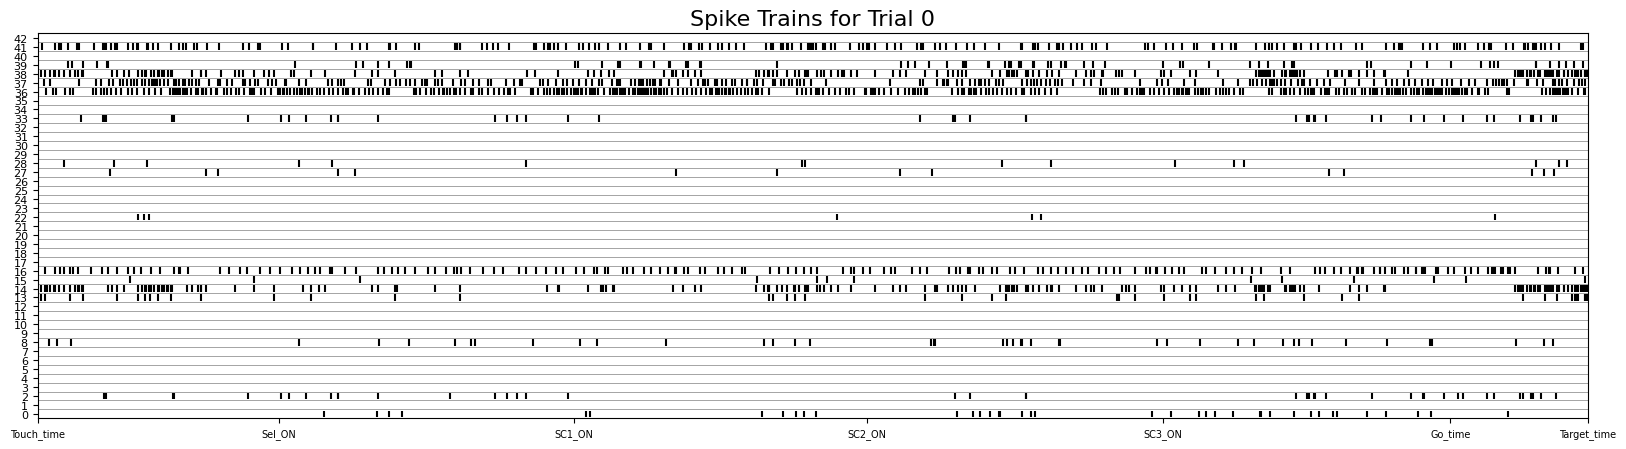

In [93]:
t = 0
event_vector = df_task_ts.loc[t]

plt.figure(figsize=(20, 5))  # Ajustez la taille de la figure selon vos besoins

# Parcourir tous les neurones et tracer leur spike train
for n in range(n_neurons): 
    spiketrain = spikes_times_aligned[n][t]['spike_train']
    if len(spiketrain) > 0 and spiketrain[0] != 0:      
        plt.eventplot(spiketrain.magnitude, linelengths=0.75, lineoffsets=n, color='black')
for i in range(n_neurons - 1):
    plt.hlines(i+0.5, xmin=event_vector.min(), xmax=event_vector.max(), colors='gray', linestyles='solid', linewidth=0.5)

# Définir les étiquettes de l'axe x et l'axe y
plt.xticks(event_vector.values, event_labels, fontsize=7)
plt.yticks(range(n_neurons), [f"{i}" for i in range(n_neurons)], fontsize=8)
plt.title(f"Spike Trains for Trial {t}", fontsize=16)

# Ajuster les limites des axes
plt.xlim(event_vector.min(), event_vector.max())
plt.ylim(-0.5, 42.5)

plt.show()


# ISI Draft

## For one Trial

def compute_isi(x, y):
    x_isi = np.diff(x)
    y_isi = np.diff(y)

    return x_isi, y_isi

n_neurons_ = 2 
n_trials_ = 1
n_times = spikes_times_aligned[n][121]['t_stop']

for n in range(2 - 1):
    spiketrain1 = spikes_times_aligned[n][121]['spike_time']
    spiketrain2 = spikes_times_aligned[n+1][121]['spike_time']

    x_isi, y_isi = compute_isi(spiketrain1, spiketrain2)
    #time = np.zeros(spikes_times_aligned[n][121]['t_stop'])
    x_isi_in_time = np.zeros(n_times)
    y_isi_in_time = np.zeros(n_times)

    for ts_idx, ts in enumerate(spiketrain1[:-1]): 
        x_isi_in_time[ts : ts + x_isi[ts_idx]] = x_isi[ts_idx]

    for ts_idx, ts in enumerate(spiketrain2[:-1]): 
        y_isi_in_time[ts : ts + y_isi[ts_idx]] = y_isi[ts_idx]


    I_isi = np.zeros(n_times)

    for t in range(n_times) :
        x_t = x_isi_in_time[t]
        y_t = y_isi_in_time[t]

        if x_t == 0 and y_t == 0:
            I_isi[t] =  0  

        elif x_t == 0 and y_t > 0: 
            I_isi[t] =  -1

        elif x_t > 0 and y_t == 0: 
            I_isi[t] =  1

        elif x_t <= y_t :
            I_isi[t] =  x_t / y_t - 1

        else:
            I_isi[t] = - (y_t / x_t - 1) 
        


print(spiketrain1)
print(x_isi)
plt.figure()
plt.plot(x_isi_in_time)
plt.plot(y_isi_in_time)
plt.figure()
plt.plot(I_isi)
plt.ylim(-1.1, 1.1)

## For two trials 

mask_tri = np.tri(n_units, n_units, -1, dtype=bool)

neuron1 = np.repeat(np.arange(n_units).reshape([-1,1]), n_units, axis=1)
neuron2 = np.repeat(np.arange(n_units).reshape([1,-1]), n_units, axis=0)

neuron1 = neuron1[mask_tri]
neuron2 = neuron2[mask_tri]

for unit in range(len(neuron1)) :
    n1 = neuron1[unit]
    n2 = neuron2[unit]

I_isi = np.zeros((n_trials, n_units, n_units), dtype=object)

for t in range(2):
    print(f'trial : {t}')
    n_times = spikes_times_aligned[0][t]['t_stop']
    i_isi = np.zeros((n_units, n_units, n_times))

    for n1 in range(n_units):
        print(f'neurone 1 : {n1}')
        spiketrain1 = spikes_times_aligned[n1][t]['spike_time']
        
        for n2 in range(n_units):
            spiketrain2 = spikes_times_aligned[n2][t]['spike_time']

            x_isi, y_isi = compute_isi(spiketrain1, spiketrain2)
            #time = np.zeros(spikes_times_aligned[n][121]['t_stop'])
            x_isi_in_time, y_isi_in_time = np.zeros(n_times), np.zeros(n_times)

            for ts_idx, ts in enumerate(spiketrain1[:-1]): 
                x_isi_in_time[ts : ts + x_isi[ts_idx]] = x_isi[ts_idx]

            for ts_idx, ts in enumerate(spiketrain2[:-1]): 
                y_isi_in_time[ts : ts + y_isi[ts_idx]] = y_isi[ts_idx]


            for time in range(n_times) :
                x_t = x_isi_in_time[time]
                y_t = y_isi_in_time[time]

                if x_t == 0 and y_t == 0:
                    i_isi[n1, n2, time] =  0  

                elif x_t == 0 and y_t > 0: 
                     i_isi[n1, n2, time] =  -1

                elif x_t > 0 and y_t == 0: 
                     i_isi[n1, n2, time] =  1

                elif x_t <= y_t :
                    i_isi[n1, n2, time] =  x_t / y_t - 1

                else:
                     i_isi[n1, n2, time] = - (y_t / x_t - 1) 
                

            I_isi[t, n1, n2] = i_isi[n1, n2, :]


# ISI updated 

In [94]:
from synchrony import ISI

In [95]:
X_isi_ = np.zeros((n_trials), dtype=object)

In [96]:
row, col = np.triu_indices(n_units, k=1)
n_pairs = len(row)
ISI_distance = []
X_isi = []

for t in range(n_trials) : 
    n_times = spikes_times_aligned[0][t]['t_stop_aligned']
    X_isi_one_trial = np.zeros((n_units, n_times))
    for n in range(n_units) :
        x_isi = ISI.compute(spikes_times_aligned[n][t]) 
        X_isi_one_trial[n, :] = x_isi

    ISI_distance_one_trials = np.zeros((n_pairs, n_times))
    for n_p, (r,c) in enumerate(zip(row, col)):
        ISI_distance_one_trials[n_p,:] = ISI.distance(X_isi_one_trial[r, :], X_isi_one_trial[c, :])
    
    X_isi.append(X_isi_one_trial)
    ISI_distance.append(ISI_distance_one_trials)

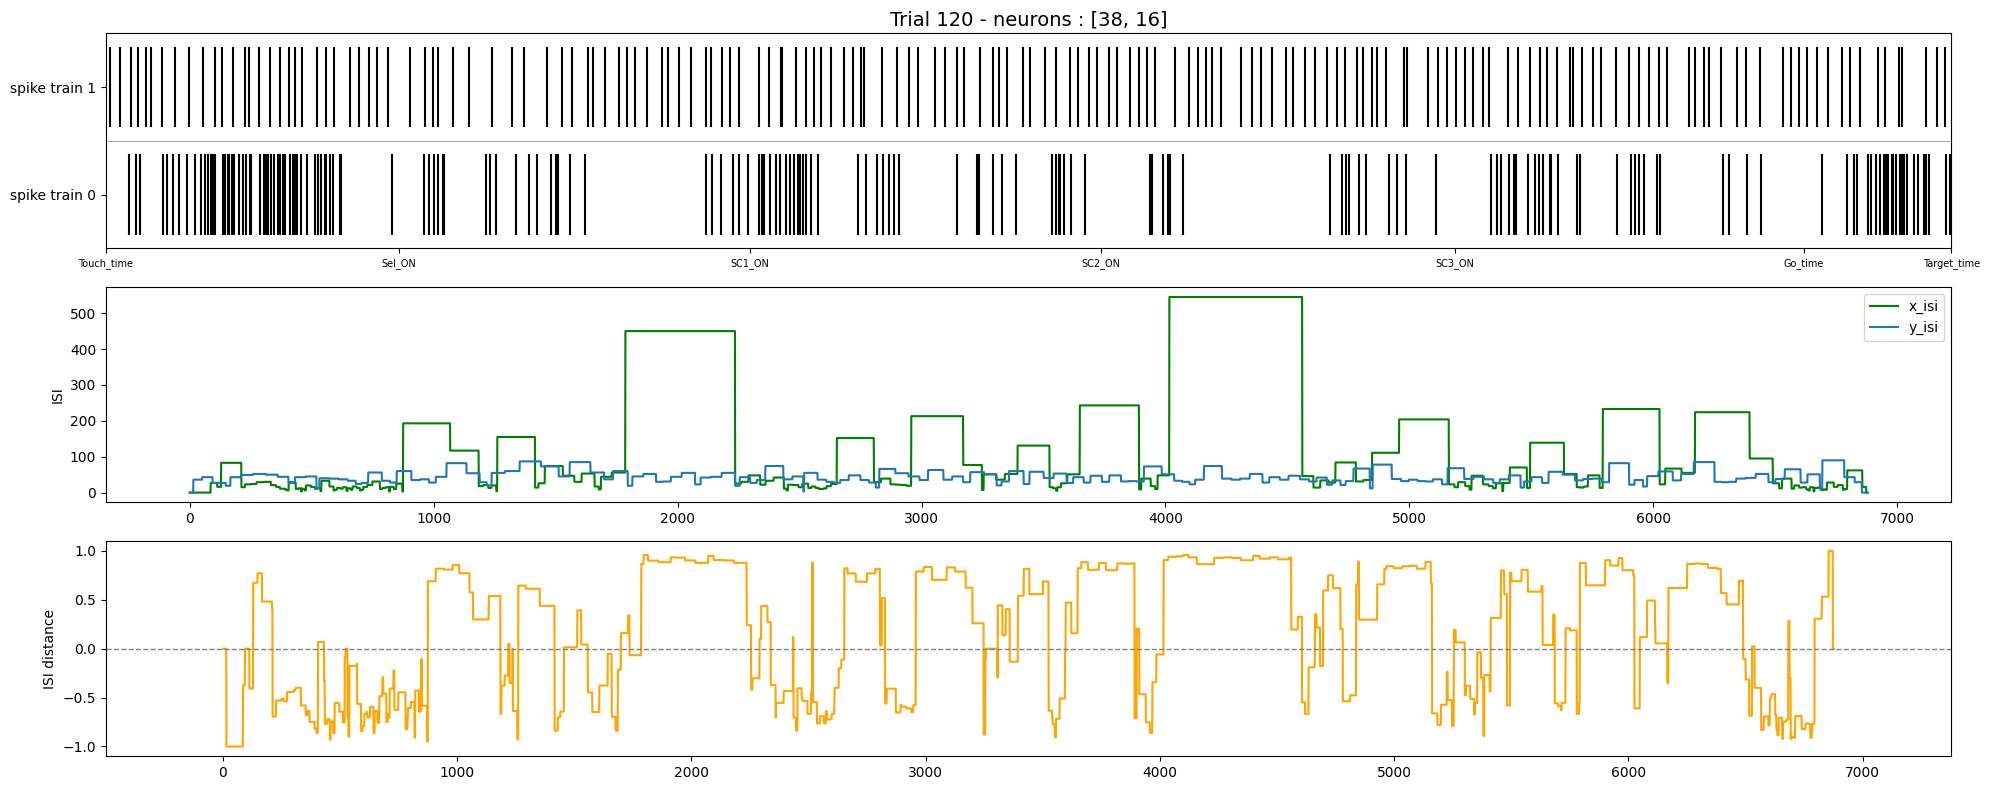

In [97]:
t = 120
neurons_ = [38,16]
event_vector = df_task_ts.loc[t]

fig, axs = plt.subplots(3,1, figsize=(20, 8))

# Parcourir tous les neurones et tracer leur spike train
for idx, n in enumerate(neurons_) : 
    spiketrain = spikes_times_aligned[n][t]['spike_train']
    if len(spiketrain) > 0 and spiketrain[0] != 0:      
        axs[0].eventplot(spiketrain.magnitude, linelengths=0.75, lineoffsets=idx, color='black')
for i in range(len(neurons_) - 1):
    axs[0].hlines(i+0.5, xmin=event_vector.min(), xmax=event_vector.max(), colors='gray', linestyles='solid', linewidth=0.5)

# Définir les étiquettes de l'axe x et l'axe y
axs[0].set_xticks(event_vector.values)
axs[0].set_xticklabels(event_labels, fontsize=7)
axs[0].set_yticks(range(n_neurons))
axs[0].set_yticklabels([f"spike train {i}" for i in range(n_neurons)], fontsize=10)
axs[0].set_title(f"Trial {t} - neurons : {neurons_}", fontsize=14)

# Ajuster les limites des axes
axs[0].set_xlim(event_vector.min(), event_vector.max())
axs[0].set_ylim(-0.5, len(neurons_)-0.5)


x_isi_in_time = ISI.compute(spikes_times_aligned[neurons_[0]][t])
y_isi_in_time = ISI.compute(spikes_times_aligned[neurons_[1]][t]) 
ISI_distance_ = ISI.distance(x_isi_in_time, y_isi_in_time)


# Create a figure with two subplots
# Plot x_isi and y_isi in the first column
axs[1].plot(x_isi_in_time, color = 'green', label='x_isi')
axs[1].plot(y_isi_in_time, label='y_isi')
axs[1].set_ylabel('ISI', fontsize=10)
axs[1].legend()

# Plot isi_dist in the second column
axs[2].plot(ISI_distance_, color='orange')
axs[2].set_ylabel('ISI distance', fontsize=10)
axs[2].hlines(0, xmin=-500, xmax=ISI_distance_.shape[0]+ 500, colors='gray', linestyles='dashed', linewidth=1)
axs[2].set_xlim(-500, ISI_distance_.shape[0] + 500)  # Set x-axis limits

plt.tight_layout()

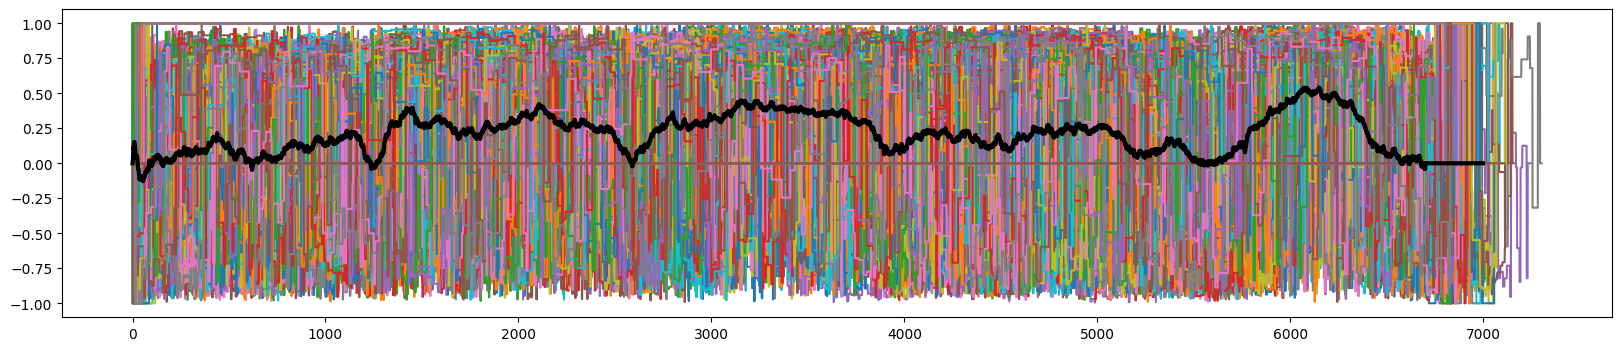

In [98]:
plt.figure(figsize=(20, 4))
ISI_dist_mean = np.zeros([7000])
for t in range(n_trials):
  x_isi_in_time = ISI.compute(spikes_times_aligned[neurons_[0]][t])
  y_isi_in_time = ISI.compute(spikes_times_aligned[neurons_[1]][t]) 
  ISI_distance_ = ISI.distance(x_isi_in_time, y_isi_in_time)
  ISI_dist_mean[:6700] += ISI_distance_[:6700]

  plt.plot(ISI_distance_)  
plt.plot(ISI_dist_mean/n_trials, linewidth=3, c='k') 

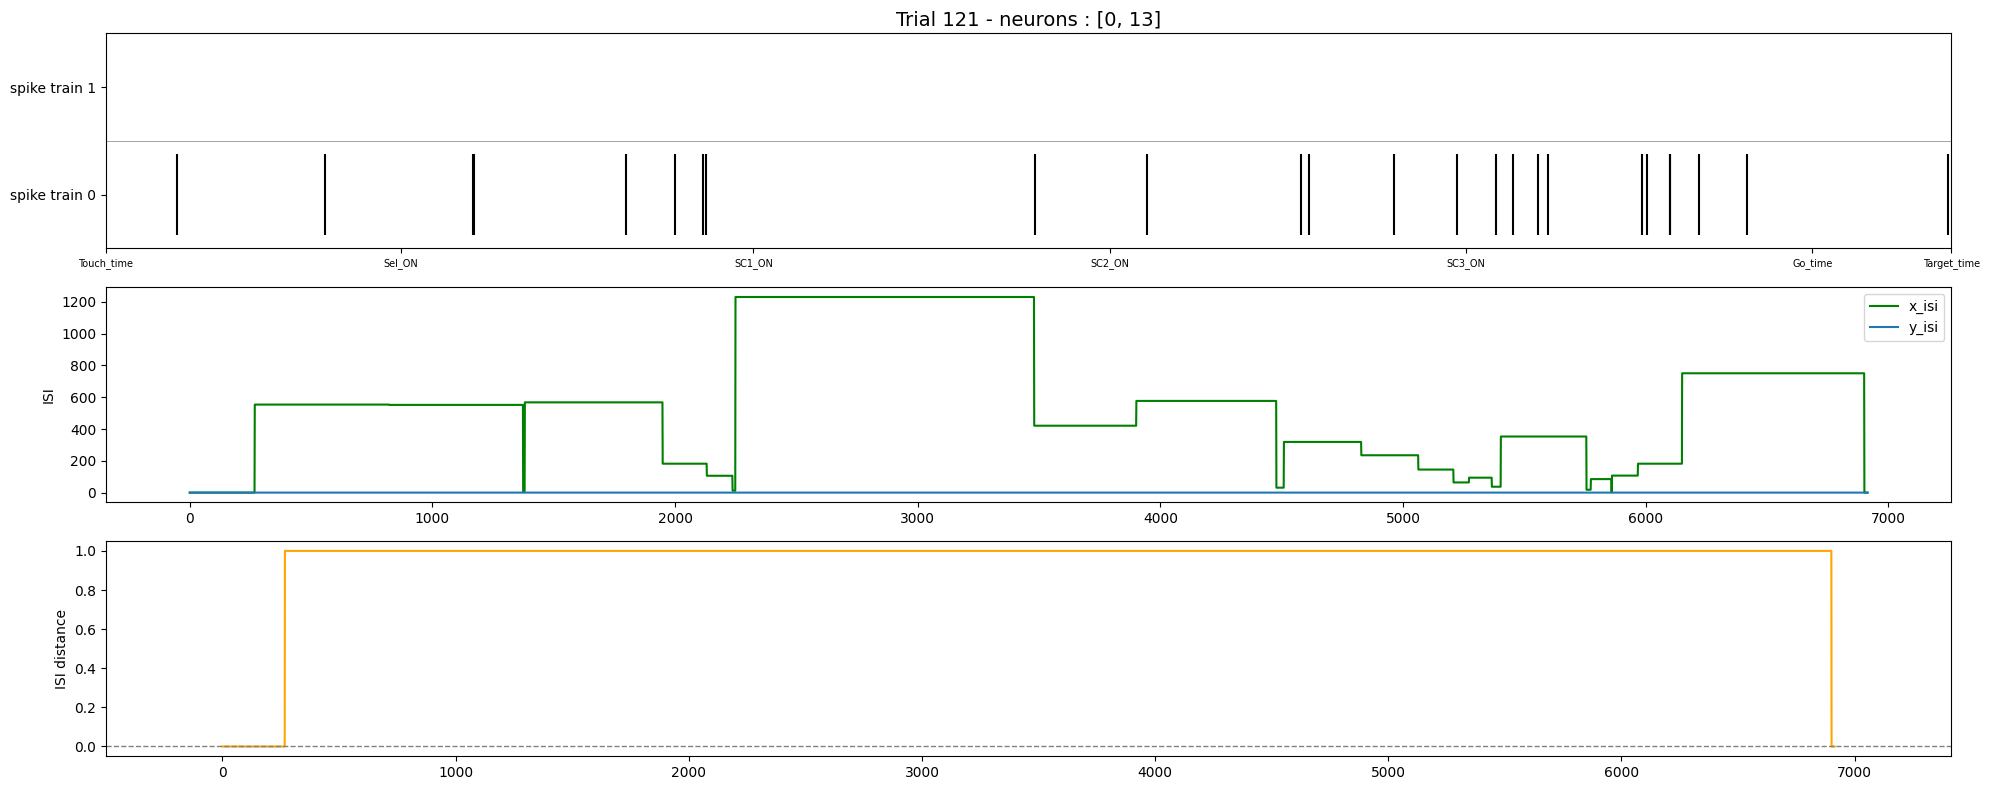

In [99]:
t = 121
neurons_ = [0,13]
event_vector = df_task_ts.loc[t]

fig, axs = plt.subplots(3,1, figsize=(20, 8))

# Parcourir tous les neurones et tracer leur spike train
for idx, n in enumerate(neurons_) :
    spiketrain = spikes_times_aligned[n][t]['spike_train']

    if len(spiketrain) > 0 and spiketrain[0] != 0:      
        axs[0].eventplot(spiketrain.magnitude, linelengths=0.75, lineoffsets=idx, color='black')
for i in range(len(neurons_) - 1):
    axs[0].hlines(i+0.5, xmin=event_vector.min(), xmax=event_vector.max(), colors='gray', linestyles='solid', linewidth=0.5)

# Définir les étiquettes de l'axe x et l'axe y
axs[0].set_xticks(event_vector.values)
axs[0].set_xticklabels(event_labels, fontsize=7)
axs[0].set_yticks(range(n_neurons))
axs[0].set_yticklabels([f"spike train {n}" for n in range(n_neurons)], fontsize=10)
axs[0].set_title(f"Trial {t} - neurons : {neurons_}", fontsize=14)

# Ajuster les limites des axes
axs[0].set_xlim(event_vector.min(), event_vector.max())
axs[0].set_ylim(-0.5, len(neurons_)-0.5)


x_isi_in_time = ISI.compute(spikes_times_aligned[neurons_[0]][t])
y_isi_in_time = ISI.compute(spikes_times_aligned[neurons_[1]][t]) 
ISI_distance_ = ISI.distance(x_isi_in_time, y_isi_in_time)


# Create a figure with two subplots
# Plot x_isi and y_isi in the first column
axs[1].plot(x_isi_in_time, color = 'green', label='x_isi')
axs[1].plot(y_isi_in_time, label='y_isi')
axs[1].set_ylabel('ISI', fontsize=10)
axs[1].legend()
0
# Plot isi_dist in the second column
axs[2].plot(ISI_distance_, color='orange')
axs[2].set_ylabel('ISI distance', fontsize=10)
axs[2].hlines(0, xmin=-500, xmax=ISI_distance_.shape[0]+ 500, colors='gray', linestyles='dashed', linewidth=1)
axs[2].set_xlim(-500, ISI_distance_.shape[0] + 500)  # Set x-axis limits

plt.tight_layout()

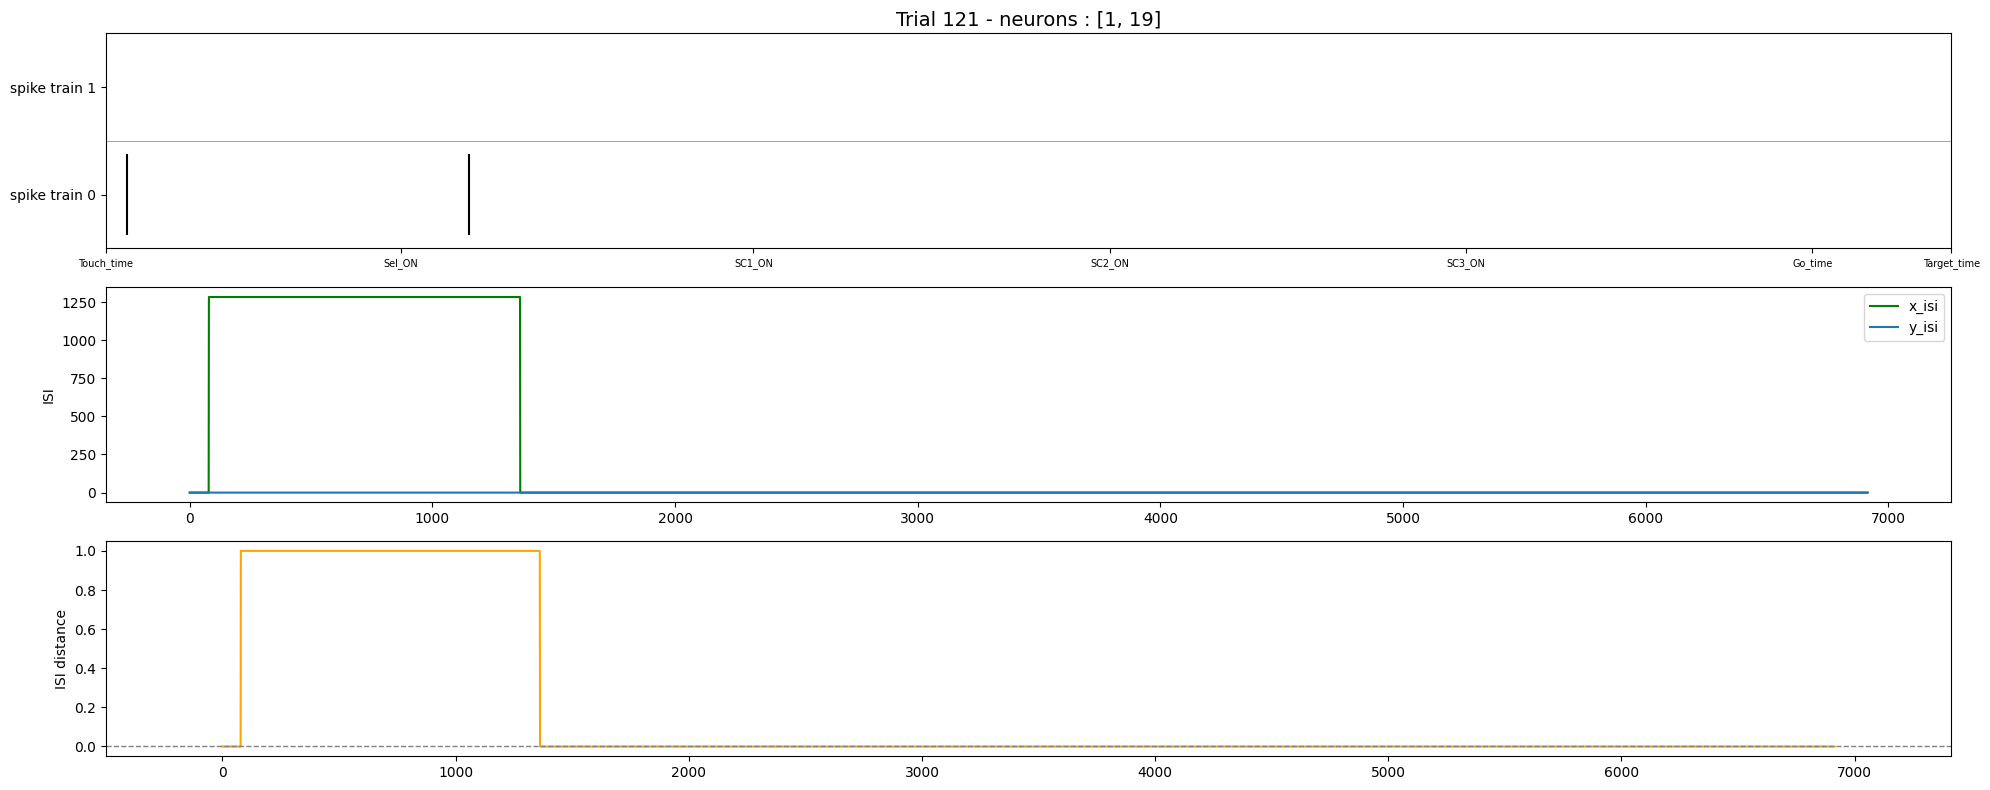

In [100]:
t = 121
neurons_ = [1,19]
event_vector = df_task_ts.loc[t]

fig, axs = plt.subplots(3,1, figsize=(20, 8))

# Parcourir tous les neurones et tracer leur spike train
for idx, n in enumerate(neurons_) :
    spiketrain = spikes_times_aligned[n][t]['spike_train']

    if len(spiketrain) > 0 and spiketrain[0] != 0:      
        axs[0].eventplot(spiketrain.magnitude, linelengths=0.75, lineoffsets=idx, color='black')
for i in range(len(neurons_) - 1):
    axs[0].hlines(i+0.5, xmin=event_vector.min(), xmax=event_vector.max(), colors='gray', linestyles='solid', linewidth=0.5)

# Définir les étiquettes de l'axe x et l'axe y
axs[0].set_xticks(event_vector.values)
axs[0].set_xticklabels(event_labels, fontsize=7)
axs[0].set_yticks(range(n_neurons))
axs[0].set_yticklabels([f"spike train {n}" for n in range(n_neurons)], fontsize=10)
axs[0].set_title(f"Trial {t} - neurons : {neurons_}", fontsize=14)

# Ajuster les limites des axes
axs[0].set_xlim(event_vector.min(), event_vector.max())
axs[0].set_ylim(-0.5, len(neurons_)-0.5)


x_isi_in_time = ISI.compute(spikes_times_aligned[neurons_[0]][t])
y_isi_in_time = ISI.compute(spikes_times_aligned[neurons_[1]][t]) 
ISI_distance_ = ISI.distance(x_isi_in_time, y_isi_in_time)


# Create a figure with two subplots
# Plot x_isi and y_isi in the first column
axs[1].plot(x_isi_in_time, color = 'green', label='x_isi')
axs[1].plot(y_isi_in_time, label='y_isi')
axs[1].set_ylabel('ISI', fontsize=10)
axs[1].legend()

# Plot isi_dist in the second column
axs[2].plot(ISI_distance_, color='orange')
axs[2].set_ylabel('ISI distance', fontsize=10)
axs[2].hlines(0, xmin=-500, xmax=ISI_distance_.shape[0]+ 500, colors='gray', linestyles='dashed', linewidth=1)
axs[2].set_xlim(-500, ISI_distance_.shape[0] + 500)  # Set x-axis limits

plt.tight_layout()

# ISI Interpolation

In [101]:
def get_max_length(n_trials, ISI_distance):
    time_ = np.zeros((n_trials), dtype=int)
    for t in range(n_trials): 
        time_[t] = ISI_distance[t].shape[1]
    max_length = np.max(time_)

    return max_length, time_

In [102]:
def interpolate_ISI_distance(ISI_distance,  max_length):
    len_trial = ISI_distance.shape[0]
    ISI_distance_interp_ = np.full(max_length, np.nan)
    ISI_distance_interp_[:len_trial] = ISI_distance
    return ISI_distance_interp_

def interpolate_X_isi(X_isi,  max_length):
    len_trial = X_isi.shape[0]
    X_isi_interp_ = np.full(max_length, np.nan)
    X_isi_interp_ = np.full(max_length, np.nan)
    X_isi_interp_[:len_trial] = X_isi
    return X_isi_interp_

In [103]:
X_isi[0][0].shape

(6923,)

In [104]:
max_length, time = get_max_length(n_trials, ISI_distance)
ISI_distance_interp = np.zeros((n_trials, max_length, n_pairs), dtype=np.float32)
X_isi_interp = np.zeros((n_trials, max_length, n_neurons), dtype=np.float32)


for t in range(n_trials):
        for p in range(n_pairs):
                ISI_distance_interp[t, :, p]  = interpolate_ISI_distance(ISI_distance[t][p], max_length)
        for n in range(n_neurons) : 
                X_isi_interp[t, :, n] = interpolate_X_isi(X_isi[t][n], max_length)
        

# Firing rate (fr) convolution

In [108]:
def binarize_spike_times(spikes_times_aligned):
    spikes_binarized = np.zeros((n_trials, max_length, n_neurons), dtype=float)
    for n in range(n_neurons):
        for t in range(n_trials):
            spiketrain = spikes_times_aligned[n][t]['spike_train']
            t_start = spikes_times_aligned[n][t]['t_start_ref'] 

            if len(spiketrain) > 0 and spiketrain[0] != 0:
                spk = spiketrain.magnitude - t_start
                spikes_binarized[t, spk, n] = 1 
            else : 
                spikes_binarized[t,:,n] = 0 
    
    return spikes_binarized
        
spikes_binarized = binarize_spike_times(spikes_times_aligned)

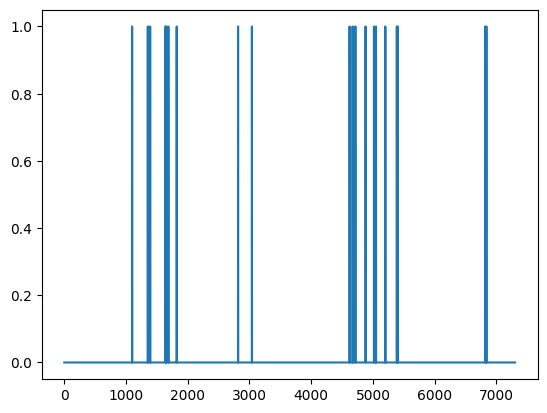

In [109]:
plt.plot(spikes_binarized[121,:,10])

In [110]:
def convolve_spike_binarized(spikes_binarized, sigma):
    n_sigma = len(sigma)
    delta_time = 1
    sigma_dt = sigma * delta_time 
    spike_convolved = np.zeros((n_trials, max_length, n_neurons, n_sigma))

    for idx, s in enumerate(sigma):
        scaling = sigma_dt[idx] * np.sqrt(2*np.pi)
        for t in range(n_trials) : 
            for n in range(n_neurons):
                smoothed_spk = spn.gaussian_filter1d(spikes_binarized[t,:,n], sigma_dt[idx]) * scaling
                spike_convolved[t,:,n,idx] = smoothed_spk
    
    return spike_convolved

In [111]:
sigma = [10, 50, 100]
spike_convolved = convolve_spike_binarized(spikes_binarized, sigma)

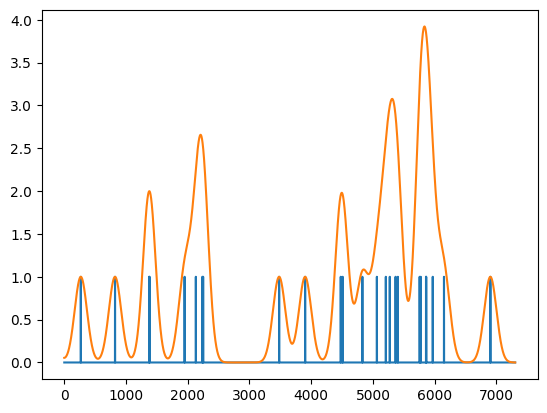

In [112]:
plt.plot(spikes_binarized[121,:,0])
plt.plot(spike_convolved[121,:,0,2])

In [146]:
spike_convolved.shape

(176, 7304, 43, 3)

# X_isi and X_FR mean by trial type 

In [147]:
X_ISI_mean = []
FR_mean = []

targets_labels = [target_1, target_2, target_3]

for target in targets_labels:
    X_ISI_mean.append(np.mean(X_isi_interp[target], axis=0))
    FR_mean.append(np.mean(spike_convolved[target, :, :, 2], axis=0))

/tmp/ipykernel_4776/945437292.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  event_time = event_vector[:] - event_vector[0]


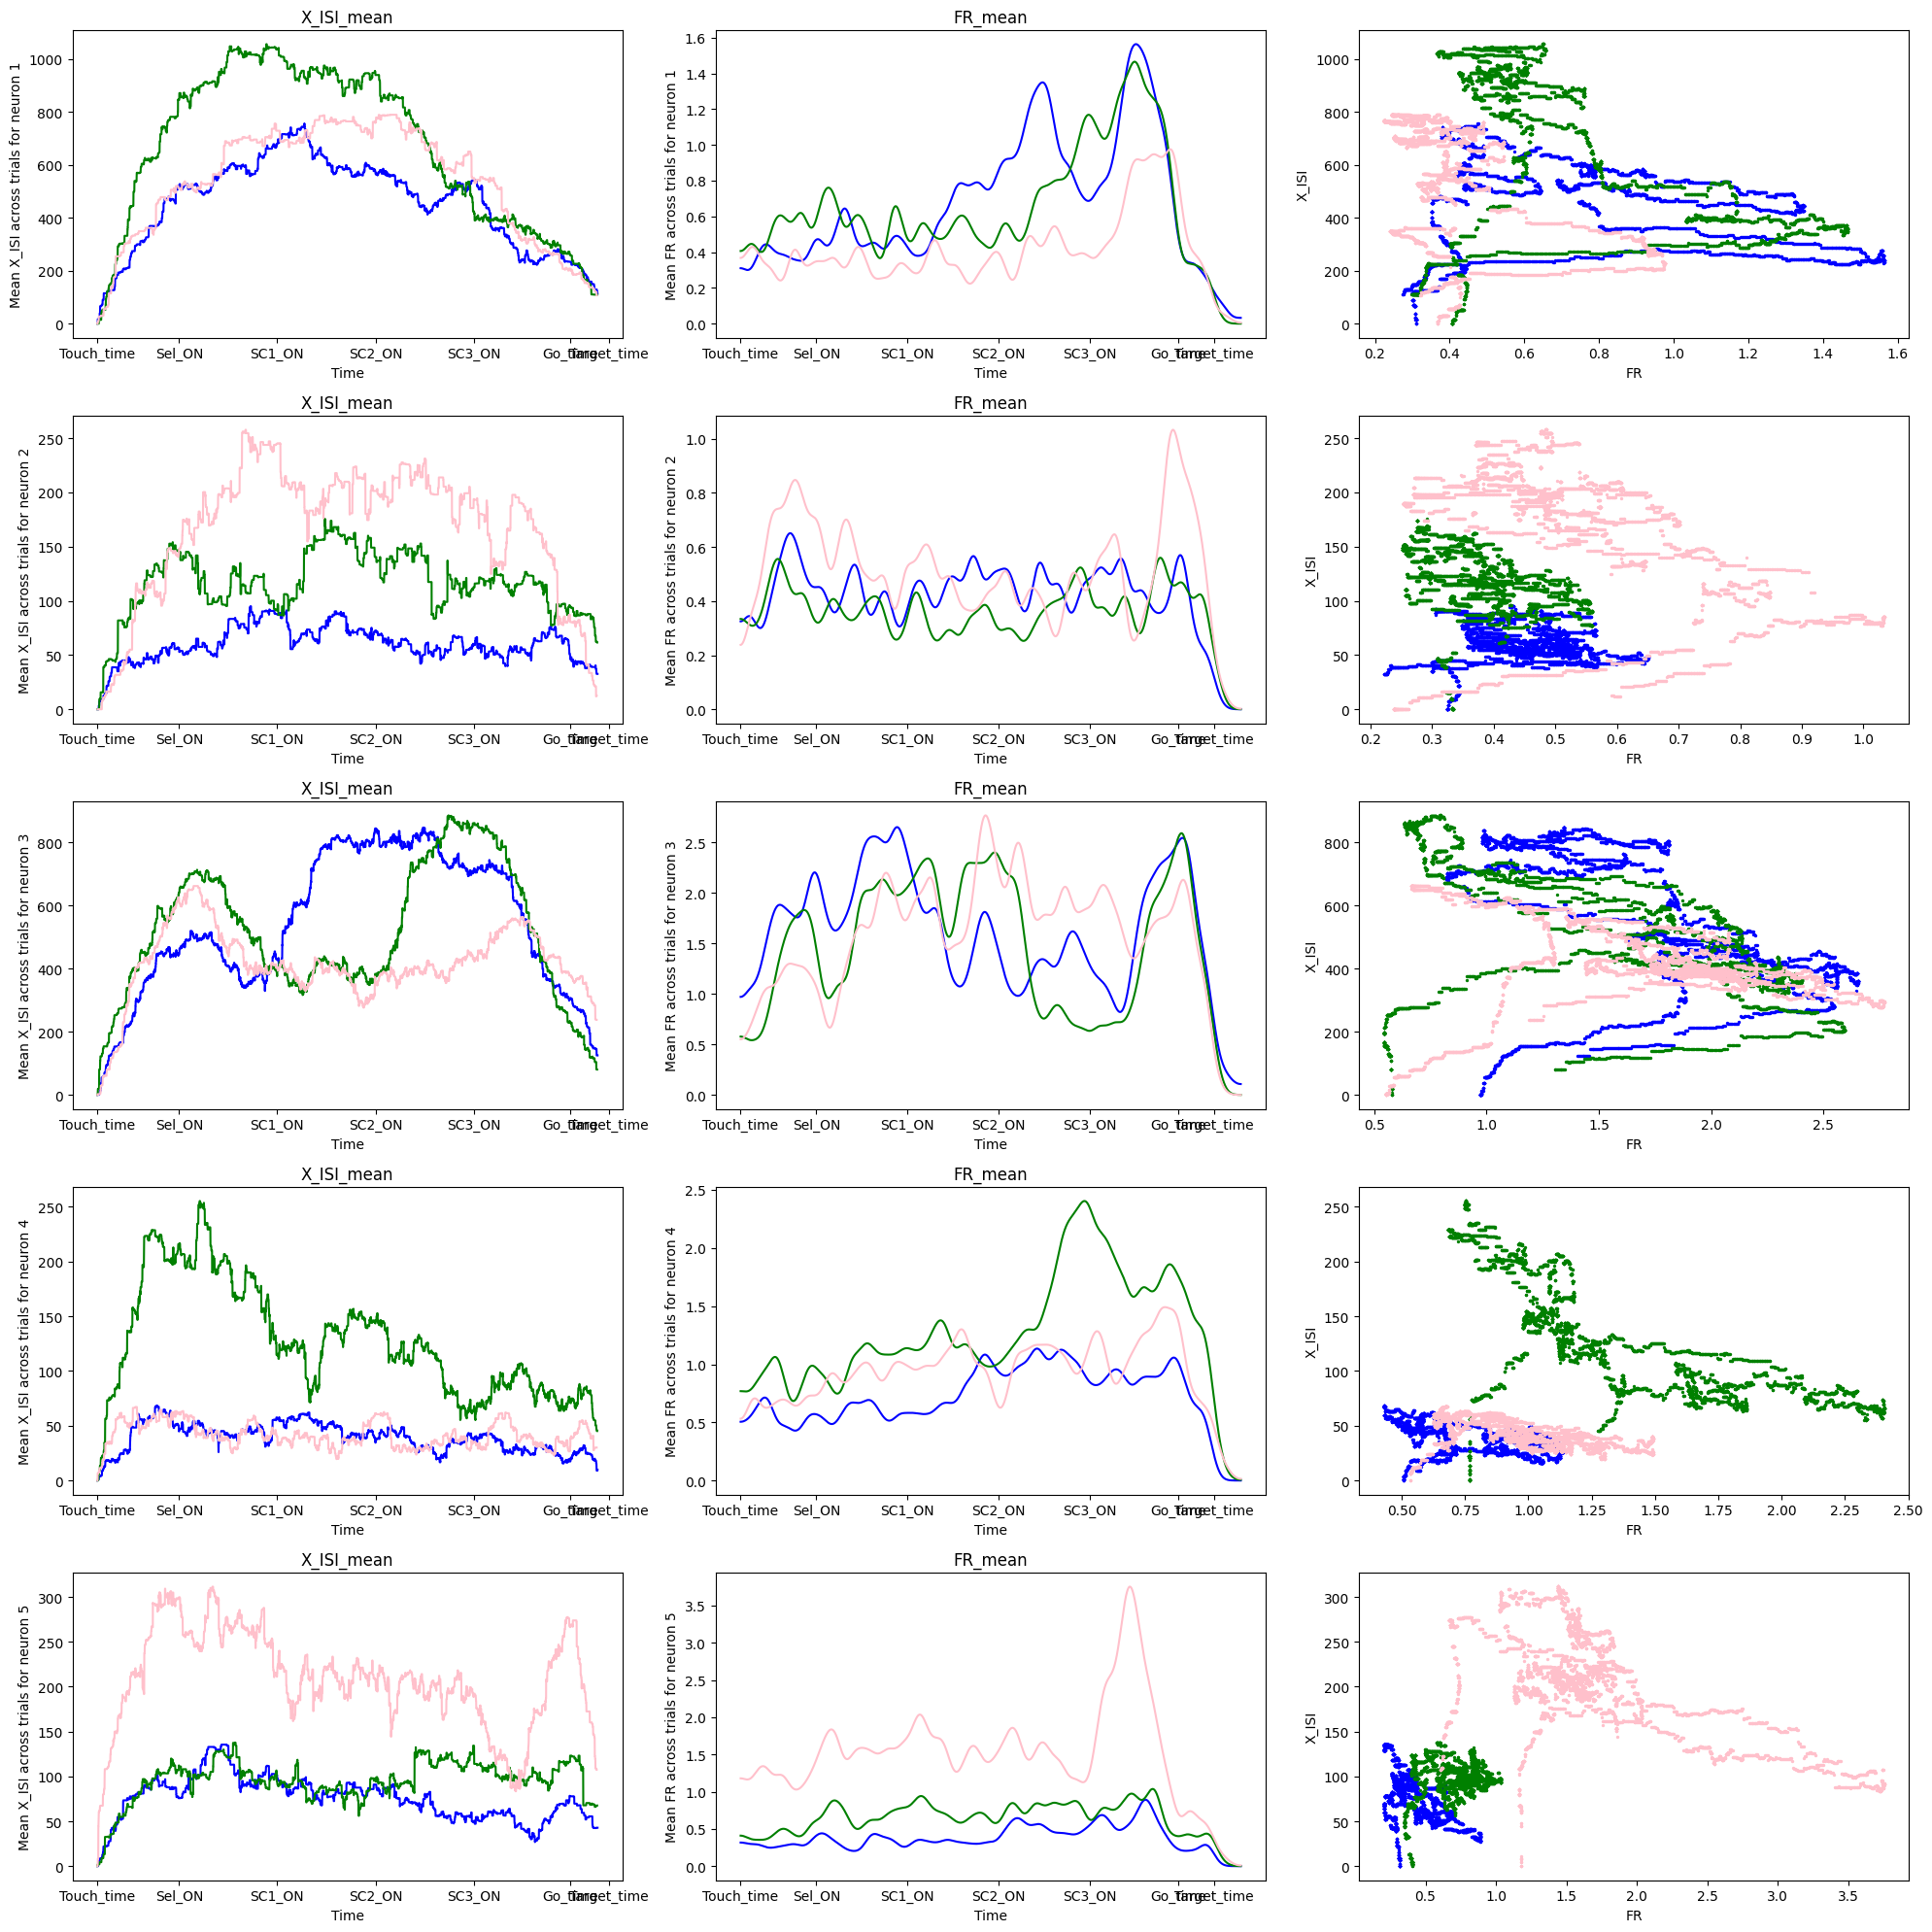

In [157]:
event_time = event_vector[:] - event_vector[0]
n_neurons_ = 5
colors = ['blue', 'green', 'pink']  # Liste de couleurs pour chaque tracé

fig, axs = plt.subplots(n_neurons_, 3, figsize=(20, 4 * n_neurons_))  # Créer une grille de sous-graphiques

for neuron_idx in range(n_neurons_):
    for idx, target in enumerate(targets_labels):
        # Tracer X_ISI_mean
        axs[neuron_idx, 0].plot(X_ISI_mean[idx][:, neuron_idx].T, color=colors[idx])
        axs[neuron_idx, 0].set_xlabel('Time')
        axs[neuron_idx, 0].set_ylabel('Mean X_ISI across trials for neuron {}'.format(neuron_idx + 1))
        axs[neuron_idx, 0].set_title('X_ISI_mean')  # Titre pour la colonne gauche

        # Tracer FR_mean
        axs[neuron_idx, 1].plot(FR_mean[idx][:, neuron_idx].T, color=colors[idx])
        axs[neuron_idx, 1].set_xlabel('Time')
        axs[neuron_idx, 1].set_ylabel('Mean FR across trials for neuron {}'.format(neuron_idx + 1))
        axs[neuron_idx, 1].set_title('FR_mean')  # Titre pour la colonne droite

        #Tracer X_ISI / X_FR_mean 
        axs[neuron_idx, 2].scatter(FR_mean[idx][:, neuron_idx], X_ISI_mean[idx][:, neuron_idx], color=colors[idx], s=2)
        axs[neuron_idx, 2].set_xlabel('FR')
        axs[neuron_idx, 2].set_ylabel('X_ISI')

        # Ajouter les étiquettes et les positions des événements sur l'axe des x
        axs[neuron_idx, 0].set_xticks(event_time.values)
        axs[neuron_idx, 0].set_xticklabels(event_labels)
        axs[neuron_idx, 1].set_xticks(event_time.values)
        axs[neuron_idx, 1].set_xticklabels(event_labels)

plt.tight_layout()  # Ajuster automatiquement les sous-graphiques pour éviter les chevauchements
plt.show()

# X_isi and X_FR corr by trial type 

In [153]:
np.corrcoef(X_ISI_mean[0][:, 0].T, FR_mean[0][:, 0].T)

array([[nan, nan],
       [nan,  1.]])

# FR/ ISI corr

In [ ]:
ISI_dist_mean

In [ ]:

# Créer une disposition de sous-tracés

# Créer une disposition de sous-tracés avec des ratios de hauteur appropriés
fig, ax = plt.subplots(2, 1, figsize=(20, 10), gridspec_kw={'height_ratios': [100, 1]})

# Tracer le heatmap sur le premier sous-tracé
heatmap = ax[0].imshow(ISI_dist_mean.T, aspect='auto', cmap='PiYG', origin='lower', extent=[0, max_length, 0, n_pairs], vmin=-1, vmax=1)
ax[0].set_xlabel('Time')
ax[0].set_ylabel('Pair Index')
ax[0].set_title('Mean ISI Distance across trials for Each Pair')

# Ajouter une ligne pour chaque paire sur le heatmap
for pair_index in range(n_pairs):
    ax[0].hlines(pair_index + 0.5, xmin=0, xmax=max_length, colors='gray', linestyles='solid', linewidth=0.1)

# Ajouter les lignes verticales pour chaque event_time
for event_time_point in event_time:
    ax[0].vlines(event_time_point, ymin=0, ymax=n_pairs, colors='red', linestyles='solid', linewidth=1)


# Ajouter les étiquettes et les positions des événements sur l'axe des x
ax[0].set_xticks(event_time.values)
ax[0].set_xticklabels(event_labels, fontsize=7)

# Ajouter la colorbar sur le deuxième sous-tracé
cbar = fig.colorbar(heatmap, cax=ax[1], orientation='horizontal')
cbar.set_label('Mean ISI Distance')
plt.subplots_adjust(top=0.9, bottom=0, left=0.1, right=0.9, hspace=0.05, wspace=0.2)
#plt.savefig('heatmap.png', dpi=300)
plt.show()

### option 2:  A travers tous les essais 

In [113]:
vx = np.random.normal(size=[100,20])
vy = np.random.normal(size=[100,20])

vx -= vx.mean(keepdims=True)
vy -= vy.mean(keepdims=True)

cov_xy = np.einsum('kt, kt -> t', vx, vy)
var_x = np.einsum('kt, kt -> t', vx, vx)
var_y = np.einsum('kt, kt -> t', vy, vy)

corr_xy = cov_xy / np.sqrt( var_x * var_y )

print(corr_xy.shape)
print(corr_xy)

(20,)
[-0.04213533  0.15783581  0.01344429  0.00523492 -0.00206841 -0.02037611
  0.03619161  0.02485575 -0.03591913  0.01973058 -0.07782863  0.16618939
  0.01415573  0.05306478 -0.18396496 -0.12358463  0.12530622  0.08687143
  0.03480786 -0.01610815]


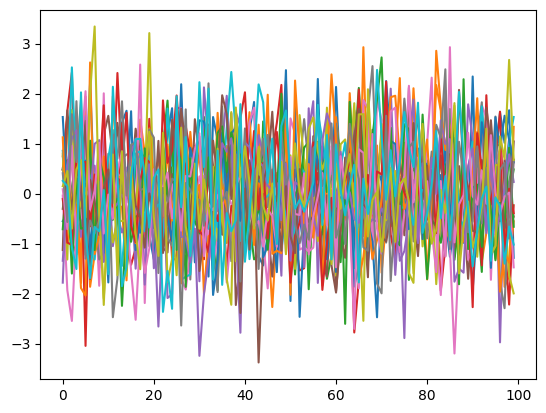

In [114]:
plt.plot(vx)

### option 1

In [115]:
x = spike_convolved[t,:,n,2]
y = X_isi_interp[t,:,n] 

support_y = np.logical_not(np.isnan(y))

print(np.isnan(x[support_y]).any())
print(np.isnan(y[support_y]).any())

print(np.corrcoef(x[support_y], y[support_y]))
print(np.corrcoef(x, y))


False
False
[[nan nan]
 [nan nan]]
[[nan nan]
 [nan nan]]


/home/INT/mifsud.l/env_classif_0423/lib/python3.11/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]


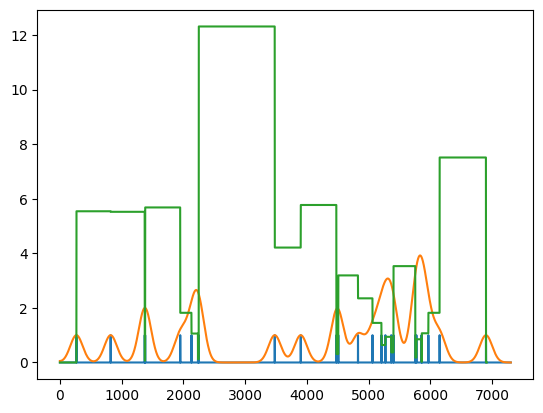

In [116]:
t = 121
n = 0
plt.plot(spikes_binarized[t,:,n])
plt.plot(spike_convolved[t,:,n,2])
plt.plot(X_isi_interp[t,:,n]/100)


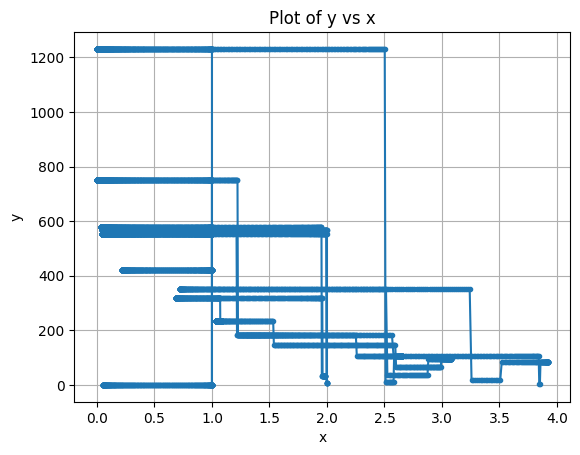

In [117]:
# Assuming you have two vectors x and y of the same length
# Replace these with your actual data 11
x = spike_convolved[t,:,n,2]
y = X_isi_interp[t,:,n]

# Plot y vs x
plt.plot(x, y, marker='.')

# Add labels and title
plt.xlabel('x')
plt.ylabel('y')
plt.title('Plot of y vs x')

# Show the plot
plt.grid(True)
plt.show()


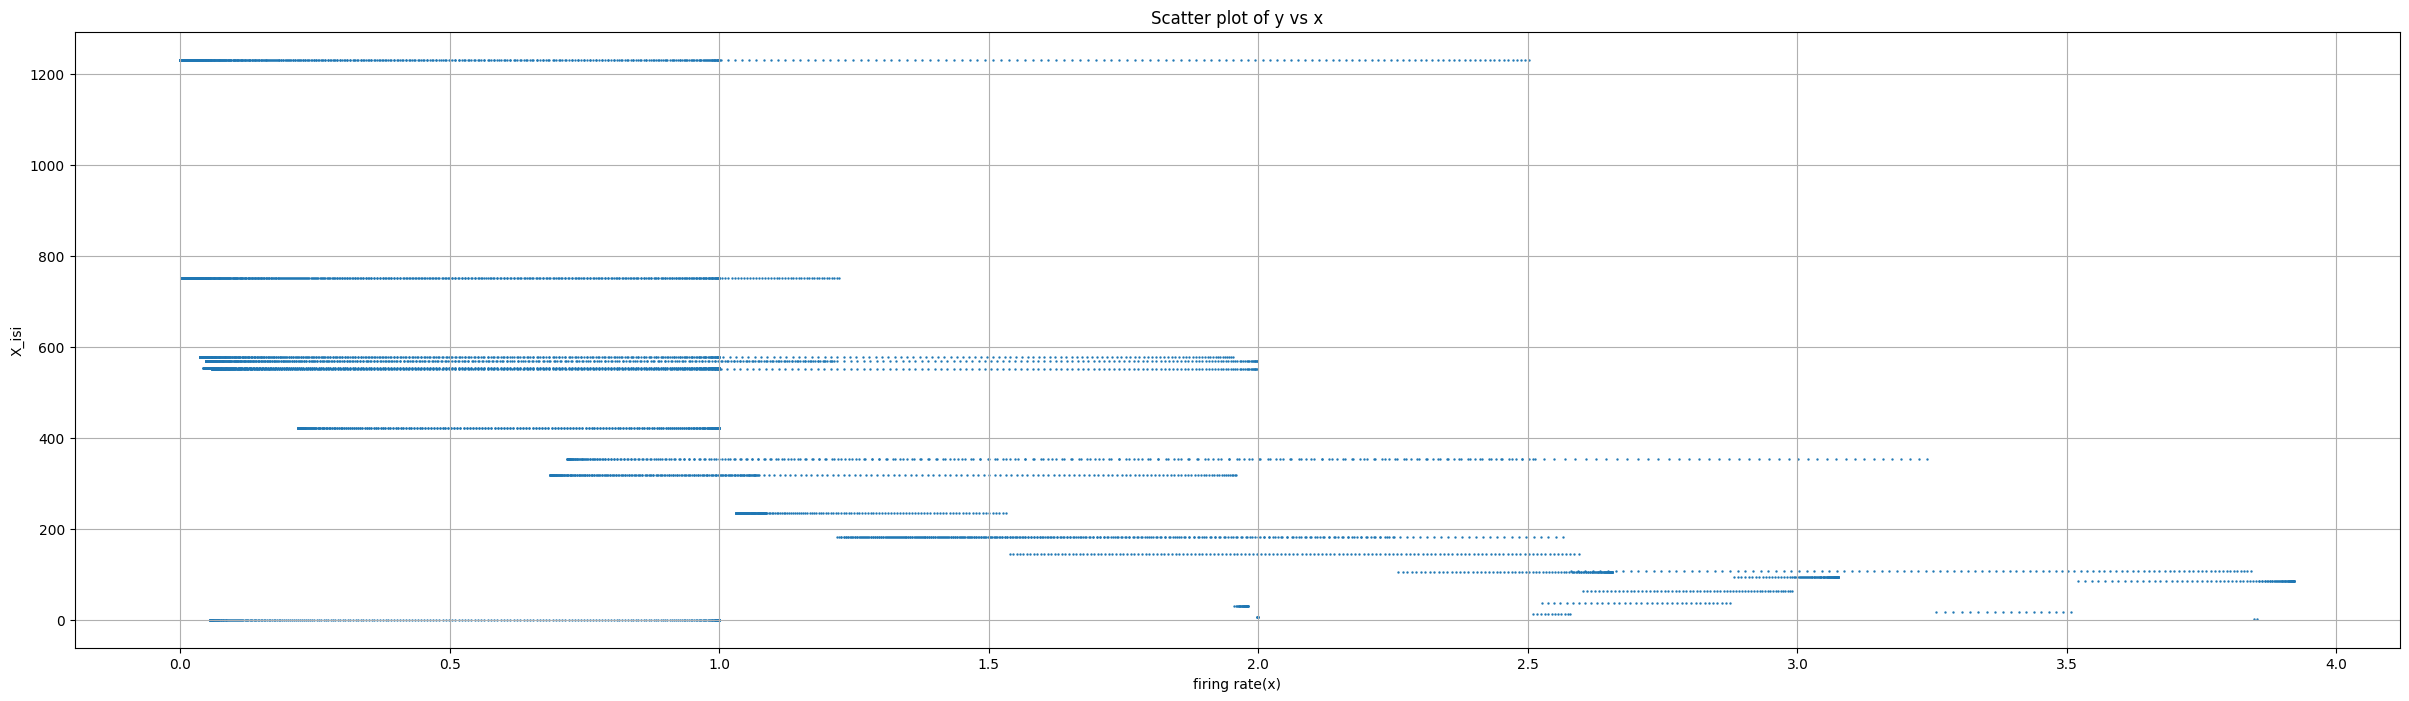

In [118]:
plt.figure(figsize=(30, 8))
x = spike_convolved[t,:,n,2]
y = X_isi_interp[t,:,n]
# Plot y vs x as a scatter plot
plt.scatter(x, y, s=0.5)

# Add labels and title
plt.xlabel('firing rate(x)')
plt.ylabel('X_isi')
plt.title('Scatter plot of y vs x')

# Show the plot
plt.grid(True)
plt.show()

In [119]:
spike_convolved.shape

(176, 7304, 43, 3)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(20,)
[ 0.03313069 -0.14481308  0.00225596 -0.02052081  0.12954582 -0.03935979
  0.03576766  0.02312225  0.09671763  0.05047009 -0.17027353  0.08995381
 -0.00576739  0.08194732  0.02808646 -0.0525137  -0.01117263 -0.01640517
  0.01851518  0.09414018]
(20,)
[ 0.1407271   0.04955941  0.18703674  0.10616595 -0.10447247 -0.14597487
  0.03878509  0.05169273  0.1158786   0.10024281  0.22897621  0.08024044
  0.19618396  0.03166508 -0.27919919  0.0115588   0.07131388  0.2203931
  0.01482804 -0.03853248]


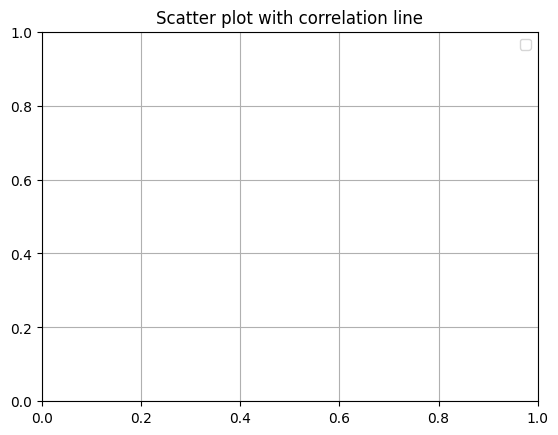

In [120]:
vx = np.random.normal(size=[100,20])
vy = np.random.normal(size=[100,20])

vx -= vx.mean(keepdims=True)
vy -= vy.mean(keepdims=True)

cov_xy = np.einsum('kt, kt -> t', vx, vy)
var_x = np.einsum('kt, kt -> t', vx, vx)
var_y = np.einsum('kt, kt -> t', vy, vy)

corr_xy = cov_xy / np.sqrt( var_x * var_y )

print(corr_xy.shape)
print(corr_xy)
y = X_isi_interp[t,:,n]
# Calculate correlation 
vx = np.random.normal(size=[100,20])
vy = np.random.normal(size=[100,20])

vx -= vx.mean(keepdims=True)
vy -= vy.mean(keepdims=True)

cov_xy = np.einsum('kt, kt -> t', vx, vy)
var_x = np.einsum('kt, kt -> t', vx, vx)
var_y = np.einsum('kt, kt -> t', vy, vy)

corr_xy = cov_xy / np.sqrt( var_x * var_y )

print(corr_xy.shape)
print(corr_xy)
plt.title('Scatter plot with correlation line')

# Add legend
plt.legend()

# Show the plot
plt.grid(True)
plt.show()


In [121]:
data = np.zeros(n_trials, dtype=object)

for t in range(n_trials) : 
    df_trial = []
    for n_p, (r,c) in enumerate(zip(row, col)):
        I =  ISI_distance_interp[t,:,n_p]
        x = spike_convolved[t, :, r, 0]
        y = spike_convolved[t, :, c, 0]
        df = pd.DataFrame({f'I({r},{c})': I, f'{r}': x, f'{c}': y})
        df_trial.append(df)

    concatenated_df = pd.concat(df_trial, axis=1)
    data[t] = concatenated_df

In [122]:
data[0]

,"I(0,1)",0,1,"I(0,2)",0,2,"I(0,3)",0,3,"I(0,4)",...,42,"I(40,41)",40,41,"I(40,42)",40,42,"I(41,42)",41,42
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,2.004887,0.0,0.0,0.0,0.0,2.004887,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.997710,0.0,0.0,0.0,0.0,1.997710,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.983613,0.0,0.0,0.0,0.0,1.983613,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.963097,0.0,0.0,0.0,0.0,1.963097,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,-1.0,0.0,1.936869,0.0,0.0,0.0,1.0,1.936869,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7299,NaN,0.0,0.0,NaN,0.0,0.0,NaN,0.0,0.0,NaN,...,0.0,NaN,0.0,0.000000,NaN,0.0,0.0,NaN,0.000000,0.0
7300,NaN,0.0,0.0,NaN,0.0,0.0,NaN,0.0,0.0,NaN,...,0.0,NaN,0.0,0.000000,NaN,0.0,0.0,NaN,0.000000,0.0
7301,NaN,0.0,0.0,NaN,0.0,0.0,NaN,0.0,0.0,NaN,...,0.0,NaN,0.0,0.000000,NaN,0.0,0.0,NaN,0.000000,0.0
7302,NaN,0.0,0.0,NaN,0.0,0.0,NaN,0.0,0.0,NaN,...,0.0,NaN,0.0,0.000000,NaN,0.0,0.0,NaN,0.000000,0.0


In [123]:
n0 = 0
n1 = 1

corr_coef = data[0].iloc[:,:3].corr(method='spearman')
corr_coef.iloc[0,1]
corr_coef

,"I(0,1)",0,1
"I(0,1)",1.00000,0.32471,NaN
0,0.32471,1.00000,NaN
1,NaN,NaN,NaN


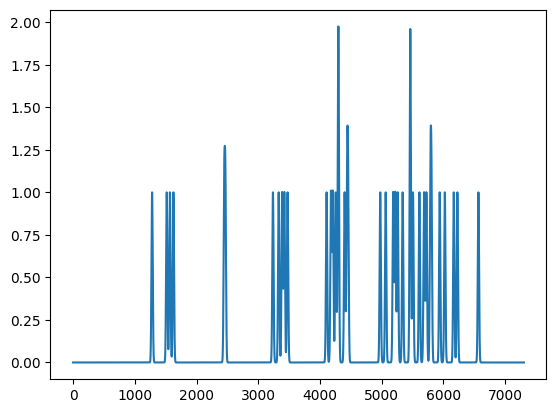

In [124]:
plt.plot(spike_convolved[0,:,0, 0])